In [1]:
import torch
from torch import nn
import dltools

In [2]:
class AttentionDecoder(dltools.Decoder):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        @property
        def attention_weighted(self):
            raise NotImplemented

In [7]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size,embed_size,num_hiddens,num_layers,dropout=0,**kwargs):
        super().__init__(**kwargs)
        self.attention = dltools.AdditiveAttention(num_hiddens,num_hiddens,num_hiddens,dropout)
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.rnn = nn.GRU(embed_size+num_hiddens,num_hiddens,num_layers,dropout=dropout)
        self.dense = nn.Linear(num_hiddens,vocab_size)

    def init_state(self, enc_outputs,enc_valid_lens, *args):
        outputs,hidden_state = enc_outputs
        return (outputs.permute(1,0,2),hidden_state,enc_valid_lens)
    

    def forward(self,X,state):
        enc_outputs,hidden_state,enc_valid_lens = state
        X = self.embedding(X)
        X = X.permute(1,0,2)
        outputs,self._attention_weights = [],[]
        for x in X:
            query = torch.unsqueeze(hidden_state[-1],dim=1)
            print(query.shape)
            context = self.attention(query,enc_outputs,enc_outputs,enc_valid_lens)
            x = torch.cat((context,torch.unsqueeze(x,dim=1)),dim=-1)
            print(x.shape)
            out,hidden_state = self.rnn(x.permute(1,0,2),hidden_state)
            print("out:",out.shape)
            print("hidden state",hidden_state.shape)
            outputs.append(out)
            self._attention_weights.append(self.attention_weights)

        outputs = self.dense(torch.cat(outputs,dim=0))
        print("解码器最终输出形状",outputs.shape)
        return outputs.permute(1,0,2),[enc_outputs,hidden_state,enc_valid_lens]
    
    @property
    def attention_weights(self):
        return self._attention_weights

In [8]:
encoder = dltools.Seq2SeqEncoder(vocab_size=10,embed_size=8,num_hiddens=16,num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10,embed_size=8,num_hiddens=16,num_layers=2)
decoder.eval()
X =torch.zeros((4,7),dtype=torch.long)
state = decoder.init_state(encoder(X),None)
output,state = decoder(X,state)
output.shape,len(state),state[0].shape,len(state[1]),state[1][0].shape

torch.Size([4, 1, 16])
torch.Size([4, 1, 24])
out: torch.Size([1, 4, 16])
hidden state torch.Size([2, 4, 16])
torch.Size([4, 1, 16])
torch.Size([4, 1, 24])
out: torch.Size([1, 4, 16])
hidden state torch.Size([2, 4, 16])
torch.Size([4, 1, 16])
torch.Size([4, 1, 24])
out: torch.Size([1, 4, 16])
hidden state torch.Size([2, 4, 16])
torch.Size([4, 1, 16])
torch.Size([4, 1, 24])
out: torch.Size([1, 4, 16])
hidden state torch.Size([2, 4, 16])
torch.Size([4, 1, 16])
torch.Size([4, 1, 24])
out: torch.Size([1, 4, 16])
hidden state torch.Size([2, 4, 16])
torch.Size([4, 1, 16])
torch.Size([4, 1, 24])
out: torch.Size([1, 4, 16])
hidden state torch.Size([2, 4, 16])
torch.Size([4, 1, 16])
torch.Size([4, 1, 24])
out: torch.Size([1, 4, 16])
hidden state torch.Size([2, 4, 16])
解码器最终输出形状 torch.Size([7, 4, 10])


(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

loss 0.021, 7214.8 tokens/sec on cuda:0


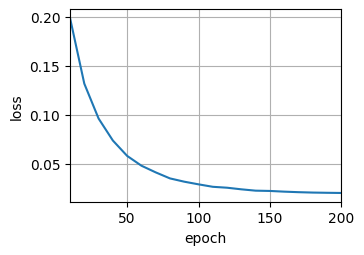

In [6]:
embed_size,num_hiddens,num_layers,dropout = 32,32,2,0.1
batch_size,num_steps = 64,10
lr,num_epochs,device = 0.005,200,dltools.try_gpu()

train_iter,src_vocab,tgt_vocab = dltools.load_data_nmt(batch_size,num_steps)
encoder = dltools.Seq2SeqEncoder(len(src_vocab),embed_size,num_hiddens,num_layers,dropout)
decoder = Seq2SeqAttentionDecoder(len(tgt_vocab),embed_size,num_hiddens,num_layers,dropout)
net = dltools.EncoderDecoder(encoder,decoder)
dltools.train_seq2seq(net,train_iter,lr,num_epochs,tgt_vocab,device)